# **Brain Tumor Classifier**

## **Problem Definition**
Classify brain MRI scans into four categories: Glioma, Meningioma, No Tumor, Pituitary.

## **Data**

Kaggle dataset with labeled MRI images.
  - **Source:**
  - **Preprocessing:** resize, normalize, augment.
  - **Split:** 70% train, 15% validation, 15% test.

## **Features**

  - **Input:** MRI images (arrays).
  - **Labels:** 4 classes (0 = Glioma, 1 = Meningioma, 2 = No Tumor, 3 = Pituitary).

## **Evaluation**

  - Hyperparameter tuning with learning rate, batch size, optimizer.
  - **Metrics:** Accuracy, Precision, Recall, F1-score, Confusion Matrix.
  - **Models Tested:**
    - Custom CNN
    - MobileNet
    - EfficientNet

In [ ]:
# Install Kaggle
!pip install -q kaggle

In [ ]:
import os
import random
import hashlib
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks, mixed_precision
from tensorflow.keras.metrics import AUC
from tensorflow.keras.applications import EfficientNetB0, MobileNetV2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import albumentations as A

In [ ]:
# Uploading Kaggle API token
files.upload()

# Setup Kaggle API environment
os.makedirs('/root/.kaggle', exist_ok=True)
!cp kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

# Download and unzip dataset
!kaggle datasets download -d tombackert/brain-tumor-mri-data
!unzip -q brain-tumor-mri-data.zip -d brain_tumor_data

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/tombackert/brain-tumor-mri-data
License(s): MIT
 83% 125M/151M [00:00<00:00, 1.31GB/s]
100% 151M/151M [00:00<00:00, 1.20GB/s]


In [ ]:
# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

**Checking for Duplicates**

Checking for duplicate images is important because duplicates do not add new information to the dataset and can bias the model, causing it to overfit or learn redundant patterns. In this dataset, I use image hashing to detect duplicates. Hashing works by converting an image into a fixed-size numerical value (hash) that uniquely represents its content. If two images are bit-for-bit identical, their hashes will be exactly the same. By comparing hashes, I can efficiently determine which images are duplicates and remove them, ensuring the dataset contains only unique images for robust model training.

In [ ]:
def remove_exact_duplicates(dataset_path):
    """
    Removes exact duplicate images from dataset subfolders.
    Keeps the first copy and deletes others.
    """
    seen_hashes = {}
    removed_files = []

    for root, _, files in os.walk(dataset_path):
        for file in files:
            filepath = os.path.join(root, file)

            try:
                with open(filepath, "rb") as f:
                    filehash = hashlib.md5(f.read()).hexdigest() # Compute MD5 hash of the file
            except:
                print(f"Could not read {filepath}, skipping.")
                continue

            # Check for duplicates
            if filehash in seen_hashes:
                os.remove(filepath) # delete duplicate
                removed_files.append(filepath)
                # print(f"Removed duplicate: {filepath} (same as {seen_hashes[filehash]})")
            else:
                seen_hashes[filehash] = filepath

    print("\n Duplicate removal complete.")
    print(f"Total duplicates removed: {len(removed_files)}")

    return removed_files

dataset_path = "/content/brain_tumor_data/brain-tumor-mri-dataset"
removed = remove_exact_duplicates(dataset_path)


 Duplicate removal complete.
Total duplicates removed: 427


**Splitting Data**

In [ ]:
def load_dataset(data_dir):
    """
    Load MRI images from the dataset, assign labels (glioma, meningioma, notumor, pituitary),
    and split them into train (70%), validation (15%), and test (15%) sets with one-hot encoding.
    """
    import os
    import numpy as np
    import tensorflow as tf
    from sklearn.model_selection import train_test_split

    class_map = {"glioma": 0, "meningioma": 1, "notumor": 2, "pituitary": 3}
    num_classes = len(class_map)

    image_paths, labels = [], []

    # Collect image paths and corresponding labels
    for cls_name, label in class_map.items():
        folder = os.path.join(data_dir, cls_name)
        for img_file in os.listdir(folder):
            if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_paths.append(os.path.join(folder, img_file))
                labels.append(label)

    train_paths, temp_paths, train_labels, temp_labels = train_test_split(
        image_paths, labels, test_size=0.3, stratify=labels, random_state=42
    )

    val_paths, test_paths, val_labels, test_labels = train_test_split(
        temp_paths, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42
    )

    train_labels = tf.keras.utils.to_categorical(train_labels, num_classes).astype(np.float32)
    val_labels = tf.keras.utils.to_categorical(val_labels, num_classes).astype(np.float32)
    test_labels = tf.keras.utils.to_categorical(test_labels, num_classes).astype(np.float32)

    return (train_paths, train_labels), (val_paths, val_labels), (test_paths, test_labels)

**Image Augmentation**

Image augmentation is a powerful technique that increases the diversity of training data by applying random but realistic transformations, such as rotations, shearing, zooming, and more. This effectively expands the dataset, helping the model to generalize better to unseen data. In my work, I use the Albumentations library for image augmentation. It provides a wide range of techniques, allowing me to apply on-the-fly augmentation, where random transformations are generated during training. This enables the model to see a new variation of each image in every epoch, improving generalization without increasing storage requirements.

In [ ]:
IMG_SIZE = 224

train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(p=0.2),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.5),
    A.GaussianBlur(blur_limit=(3,5), p=0.2),
    A.CoarseDropout(num_holes_range=(1,8), hole_height_range=(10,20), hole_width_range=(10,20), p=0.3),
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225))
])

val_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225))
])

/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


**Dataset Pipeline**

In [ ]:
def preprocess_image(path, label, train=True):
  """
    Loads an image from the given path, applies training or validation transformations,
    and returns the preprocessed image with its label as tf.float32 tensors.
  """
  img_path = path.numpy().decode()

  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  if train:
    img = train_transform(image=img)['image']
  else:
    img = val_transform(image=img)['image']

  return tf.cast(img, tf.float32), label

def tf_wrapper(path, label, train=True):
  """
    Wraps 'preprocess_image' using tf.py_function so it can be used in a TensorFlow pipeline,
    ensuring both image and label have fixed tensor shapes.
  """
  img, label = tf.py_function(
      func=preprocess_image,
      inp=[path, label, train],
      Tout=[tf.float32, tf.float32]
  )
  img.set_shape((IMG_SIZE, IMG_SIZE, 3))
  label.set_shape((4,))
  return img, label

In [ ]:
def build_dataset(paths, labels, train=True, batch_size=32, shuffle=True):
  """
    Creates a TensorFlow dataset from image paths and labels with optional preprocessing, shuffling, and batching.
    Supports data augmentation when train=True and prefetches for performance.
  """
  dataset = tf.data.Dataset.from_tensor_slices((paths, labels))

  if shuffle:
    dataset = dataset.shuffle(buffer_size=len(paths))

  dataset = dataset.map(lambda x, y: tf_wrapper(x, y, train), num_parallel_calls=tf.data.AUTOTUNE)

  dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

  return dataset

**Models**

I chose Custom CNN, MobileNetV2, and EfficientNetB0 as the three models to test because I wanted to explore different types of architectures and how they perform on this dataset.

- **Custom CNN:** I included this model because it is lightweight and has fewer
layers than MobileNetV2 and EfficientNetB0. It can be designed to fit the dataset’s size and complexity, allowing fast training and inference while still achieving high accuracy, making it practical for limited hardware.

- **MobileNetV2:** This is a popular pre-trained model that balances accuracy and efficiency. It has more layers than the Custom CNN but is still smaller and faster than EfficientNetB0. I wanted to see how a pre-trained model works on this dataset without using too many resources.

- **EfficientNetB0:** I included this model because it is very efficient and lightweight compared to larger models like DenseNet or ResNet. It has many layers, so it can still capture complex features, making it a strong option to test on this dataset and compare with the smaller models like Custom CNN and MobileNetV2.

In [ ]:
# Custom CNN
def build_custom_cnn(input_shape=(224,224,3), num_classes=4):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(32,(3,3),activation='relu',padding='same')(inputs)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Conv2D(64,(3,3),activation='relu',padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Conv2D(128,(3,3),activation='relu',padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128,activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax', dtype='float32')(x)
    return models.Model(inputs, outputs)

In [ ]:
# EfficientNetB0 Model
def build_efficientnetb0(input_shape=(224,224,3), num_classes=4):
    base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
    base.trainable = False

    inputs = layers.Input(shape=input_shape)
    x = base(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='softmax', dtype='float32')(x)
    return models.Model(inputs, outputs)

In [ ]:
# MobileNetv2 Model
def build_mobilenetv2(input_shape=(224,224,3), num_classes=4):
    base = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    base.trainable = False

    inputs = layers.Input(shape=input_shape)
    x = base(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='softmax', dtype='float32')(x)
    return models.Model(inputs, outputs)

**Training Function**

In [ ]:
def train_model(model_name, data_dir, batch_size=32, epochs=15):
    (train_paths, train_labels), (val_paths, val_labels), (test_paths, test_labels) = load_dataset(data_dir)

    train_ds = build_dataset(train_paths, train_labels, train=True, batch_size=batch_size)
    val_ds = build_dataset(val_paths, val_labels, train=False, batch_size=batch_size, shuffle=False)
    test_ds = build_dataset(test_paths, test_labels, train=False, batch_size=batch_size, shuffle=False)

    if model_name=="custom":
        model = build_custom_cnn()
    elif model_name=="efficientnet":
        model = build_efficientnetb0()
    elif model_name=="mobilenet":
        model = build_mobilenetv2()
    else:
        raise ValueError("Invalid model name. Choose from: custom, mobilenet, efficientnet.")

    optimizer = optimizers.Adam(1e-3)
    optimizer = mixed_precision.LossScaleOptimizer(optimizer)

    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy', AUC(name='auc')]
    )

    ckpt_path = f"best_{model_name}.keras"
    cb = [
        callbacks.ModelCheckpoint(ckpt_path, monitor='val_auc', mode='max', save_best_only=True, verbose=1),
        callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1),
        callbacks.EarlyStopping(monitor='val_auc', mode='max', patience=5, restore_best_weights=True, verbose=1)
    ]

    history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=cb)

    # Load best model
    if os.path.exists(ckpt_path):
        model = tf.keras.models.load_model(ckpt_path)

    # Evaluate
    test_loss, test_acc, test_auc = model.evaluate(test_ds)
    print(f" {model_name} Test Accuracy: {test_acc:.4f} | AUC: {test_auc:.4f} | Loss: {test_loss:.4f}")

    # Plot training curves
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Confusion Matrix and Classification Report
    y_true = np.concatenate([y for x, y in test_ds], axis=0)
    y_pred = model.predict(test_ds)
    y_true_classes = np.argmax(y_true, axis=1)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Confusion Matrix
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()

    # Classification Report
    print("\n Classification Report:")
    print(classification_report(y_true_classes, y_pred_classes))

    return history, model

Epoch 1/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.6029 - auc: 0.8279 - loss: 0.9487
Epoch 1: val_auc improved from -inf to 0.97286, saving model to best_mobilenet.keras
158/158 ━━━━━━━━━━━━━━━━━━━━ 53s 280ms/step - accuracy: 0.6037 - auc: 0.8285 - loss: 0.9470 - val_accuracy: 0.8593 - val_auc: 0.9729 - val_loss: 0.4034 - learning_rate: 0.0010
Epoch 2/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.8345 - auc: 0.9677 - loss: 0.4378
Epoch 2: val_auc improved from 0.97286 to 0.98194, saving model to best_mobilenet.keras
158/158 ━━━━━━━━━━━━━━━━━━━━ 65s 196ms/step - accuracy: 0.8345 - auc: 0.9677 - loss: 0.4377 - val_accuracy: 0.8850 - val_auc: 0.9819 - val_loss: 0.3277 - learning_rate: 0.0010
Epoch 3/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.8724 - auc: 0.9793 - loss: 0.3501
Epoch 3: val_auc improved from 0.98194 to 0.98260, saving model to best_mobilenet.keras
158/158 ━━━━━━━━━━━━━━━━━━━━ 42s 206ms/step - accuracy: 0.8724 - auc: 0.9793 - lo

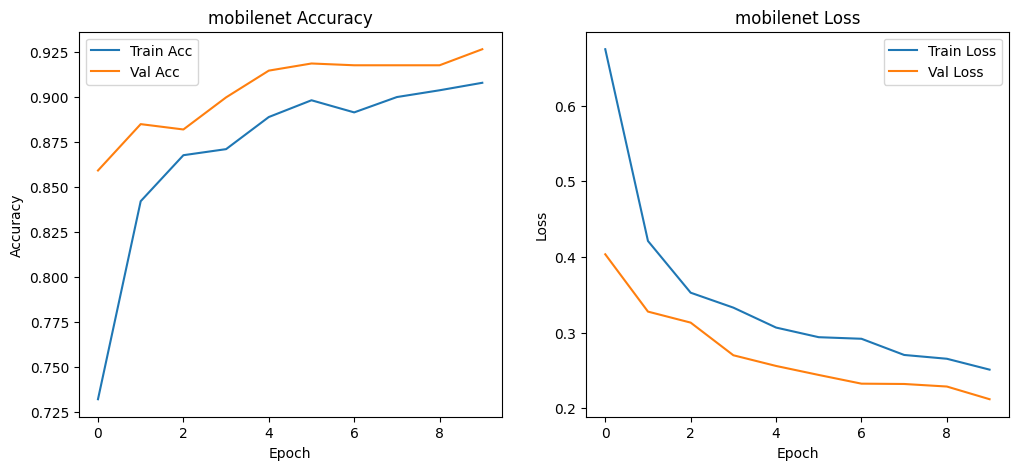

22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 310ms/step


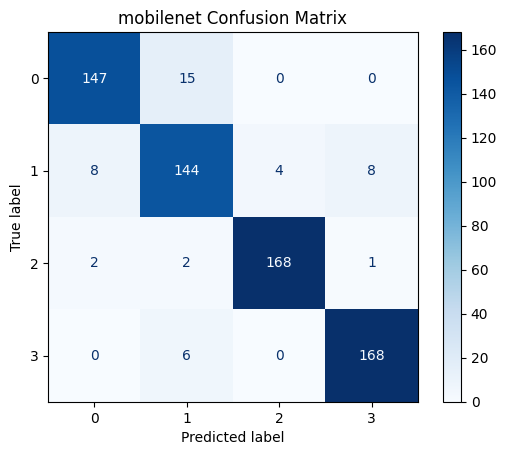


 Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.91      0.92       162
           1       0.86      0.88      0.87       164
           2       0.98      0.97      0.97       173
           3       0.95      0.97      0.96       174

    accuracy                           0.93       673
   macro avg       0.93      0.93      0.93       673
weighted avg       0.93      0.93      0.93       673



In [ ]:
# Path to the dataset
data_dir = "/content/brain_tumor_data/brain-tumor-mri-dataset"

# Train the model
mobilenet_history, mobilenet_model = train_model(
    model_name="mobilenet",
    data_dir=data_dir,
    batch_size=32,
    epochs=10
)

The MobileNet model is performing very well, with high accuracy, low loss, and strong class-wise performance. Minor confusion between classes 0 and 1 exists but does not significantly impact overall performance.

Epoch 1/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - accuracy: 0.5061 - auc: 0.7510 - loss: 1.7814
Epoch 1: val_auc improved from -inf to 0.94840, saving model to best_custom.keras
158/158 ━━━━━━━━━━━━━━━━━━━━ 53s 283ms/step - accuracy: 0.5066 - auc: 0.7515 - loss: 1.7772 - val_accuracy: 0.7849 - val_auc: 0.9484 - val_loss: 0.5651 - learning_rate: 0.0010
Epoch 2/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.7219 - auc: 0.9136 - loss: 0.7090
Epoch 2: val_auc improved from 0.94840 to 0.96962, saving model to best_custom.keras
158/158 ━━━━━━━━━━━━━━━━━━━━ 41s 257ms/step - accuracy: 0.7219 - auc: 0.9136 - loss: 0.7089 - val_accuracy: 0.8176 - val_auc: 0.9696 - val_loss: 0.4105 - learning_rate: 0.0010
Epoch 3/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.7801 - auc: 0.9430 - loss: 0.5727
Epoch 3: val_auc improved from 0.96962 to 0.98567, saving model to best_custom.keras
158/158 ━━━━━━━━━━━━━━━━━━━━ 40s 250ms/step - accuracy: 0.7801 - auc: 0.9430 - loss: 0.572

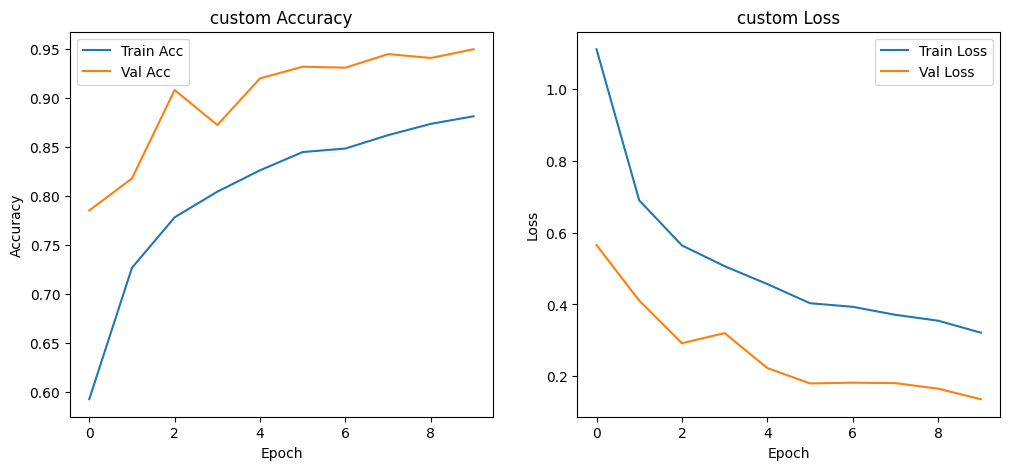

22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step


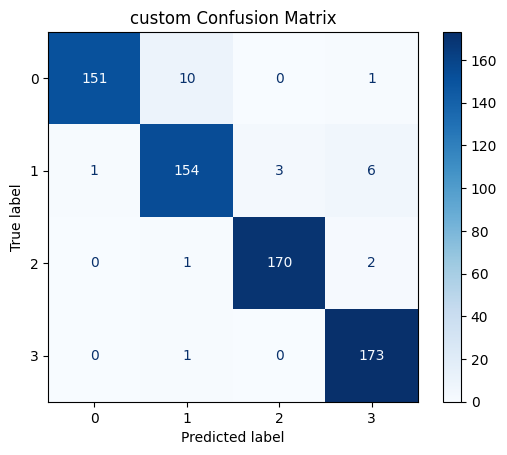


 Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.93      0.96       162
           1       0.93      0.94      0.93       164
           2       0.98      0.98      0.98       173
           3       0.95      0.99      0.97       174

    accuracy                           0.96       673
   macro avg       0.96      0.96      0.96       673
weighted avg       0.96      0.96      0.96       673



In [ ]:
custom_history, custom_model = train_model(
    model_name="custom",
    data_dir=data_dir,
    batch_size=32,
    epochs=10
)

The custom model works really well, reaching 95% accuracy on validation data with no signs of overfitting. It makes only a few mistakes, mostly between Classes 0 and 1. Overall accuracy is 96%, and all classes are predicted very well, especially Classes 2 and 3. This makes the custom model better than MobileNet with more balanced and reliable results.

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - accuracy: 0.4240 - auc: 0.6857 - loss: 1.2426
Epoch 1: val_auc improved from -inf to 0.84142, saving model to best_efficientnet.keras
158/158 ━━━━━━━━━━━━━━━━━━━━ 96s 413ms/step - accuracy: 0.4244 - auc: 0.6861 - loss: 1.2420 - val_accuracy: 0.5818 - val_auc: 0.8414 - val_loss: 0.9795 - learning_rate: 0.0010
Epoch 2/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.5865 - auc: 0.8251 - loss: 1.0199
Epoch 2: val_auc improved from 0.84142 to 0.87288, saving model to best_efficientnet.keras
158/158 ━━━━━━━━━━━━━━━━━━━━ 91s 210ms/step - accuracy: 0.5864 - auc: 0.8251 - loss: 1.0198 - val_accuracy: 0.6274 - val_auc: 0.8729 - val_loss: 0.8860 - learning_rate: 0.0010
Epoch 3/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.6168 - auc: 0.8543 - loss: 0.9434
Epoch 3: val_auc improved from 0.87288 to 0.88691, saving model to best_efficientnet.keras
158/158 ━━━━━━━━━━━━━

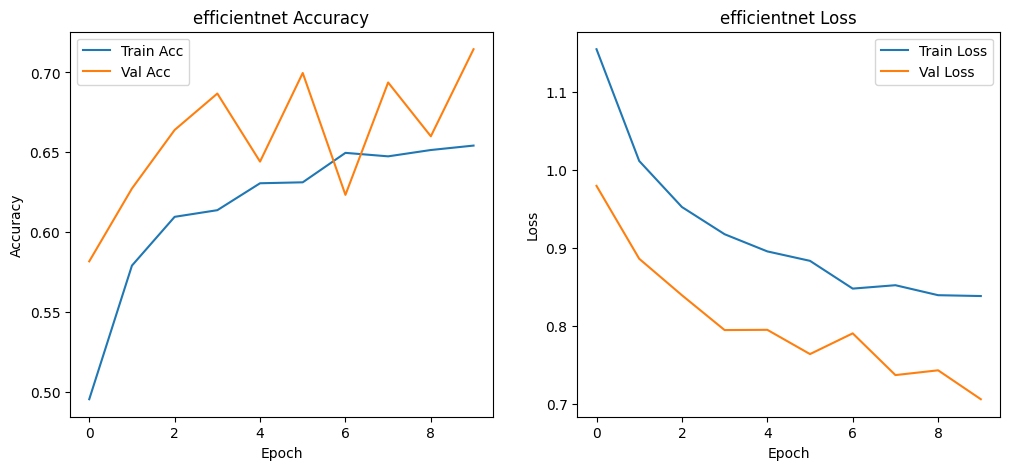

22/22 ━━━━━━━━━━━━━━━━━━━━ 16s 437ms/step


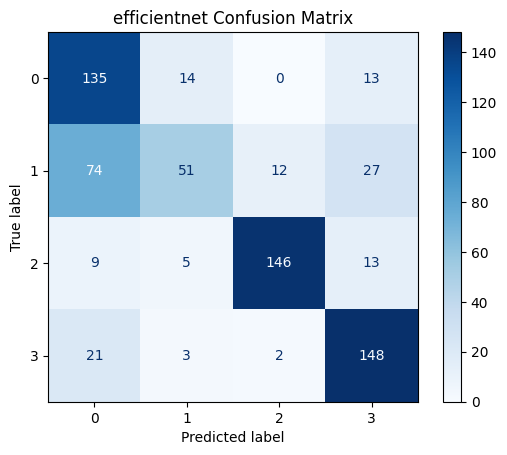


 Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.83      0.67       162
           1       0.70      0.31      0.43       164
           2       0.91      0.84      0.88       173
           3       0.74      0.85      0.79       174

    accuracy                           0.71       673
   macro avg       0.73      0.71      0.69       673
weighted avg       0.73      0.71      0.70       673



In [ ]:
data_dir = "/content/brain_tumor_data/brain-tumor-mri-dataset"

efficientnet_history, efficientnet_model = train_model(
    model_name="efficientnet",
    data_dir=data_dir,
    batch_size=32,
    epochs=10
)

The EfficientNet model improved steadily during training, reaching about 72% accuracy on validation data. It does well overall, especially on classes 2 and 3, but struggles more with class 1. The total accuracy is 71%, and the average scores (precision, recall, F1) are around 70%. This means the model is learning well but could use more work to handle class 1 better.

**Fine Tuning EfficientNet Model**

Since EfficientNet did not achieve the best performance, I decided to fine-tune the model further by unfreezing the last 20% of its layers and retraining. This approach allows the model to adjust deeper feature representations while retaining the benefits of transfer learning from the pretrained weights, with the goal of improving classification accuracy and generalization.

In [ ]:
def build_efficientnetb0_finetune(input_shape=(224,224,3), num_classes=4):
    # Load EfficientNetB0 base
    base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)

    # Unfreeze last 20 layers for fine-tuning
    for layer in base.layers[:-20]:
        layer.trainable = False
    for layer in base.layers[-20:]:
        layer.trainable = True

    # Build model
    inputs = layers.Input(shape=input_shape)
    x = base(inputs, training=True)
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='softmax', dtype='float32')(x)
    model = models.Model(inputs, outputs)

    # Compile with lower learning rate for fine-tuning
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [ ]:
def train_model(model_name, data_dir, batch_size=32, epochs=15, fine_tune=False):
    (train_paths, train_labels), (val_paths, val_labels), (test_paths, test_labels) = load_dataset(data_dir)

    train_ds = build_dataset(train_paths, train_labels, train=True, batch_size=batch_size)
    val_ds = build_dataset(val_paths, val_labels, train=False, batch_size=batch_size, shuffle=False)
    test_ds = build_dataset(test_paths, test_labels, train=False, batch_size=batch_size, shuffle=False)

    # Model selection
    if model_name=="custom":
        model = build_custom_cnn()
    elif model_name=="efficientnet":
        if fine_tune:
            model = build_efficientnetb0_finetune() # Phase 2
        else:
            model = build_efficientnetb0() # Phase 1 frozen
    elif model_name=="mobilenet":
        model = build_mobilenetv2()
    else:
        raise ValueError("Invalid model name. Choose from: custom, mobilenet, efficientnet.")

    # Optimizer
    lr = 1e-3 if not fine_tune else 1e-5 # lower learning rate for fine-tuning
    optimizer = optimizers.Adam(lr)
    optimizer = mixed_precision.LossScaleOptimizer(optimizer)

    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy', AUC(name='auc')]
    )

    # Callbacks
    ckpt_path = f"best_{model_name}{'_finetune' if fine_tune else ''}.keras"
    cb = [
        callbacks.ModelCheckpoint(ckpt_path, monitor='val_auc', mode='max', save_best_only=True, verbose=1),
        callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1),
        callbacks.EarlyStopping(monitor='val_auc', mode='max', patience=5, restore_best_weights=True, verbose=1)
    ]

    # Train
    history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=cb)

    # Load best model
    if os.path.exists(ckpt_path):
        model = tf.keras.models.load_model(ckpt_path)

    # Evaluate
    test_loss, test_acc, test_auc = model.evaluate(test_ds)
    print(f"{model_name}{'_finetune' if fine_tune else ''} Test Accuracy: {test_acc:.4f} | AUC: {test_auc:.4f} | Loss: {test_loss:.4f}")

    # Plot training curves
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Confusion Matrix and Classification Report
    y_true = np.concatenate([y for x, y in test_ds], axis=0)
    y_pred = model.predict(test_ds)
    y_true_classes = np.argmax(y_true, axis=1)
    y_pred_classes = np.argmax(y_pred, axis=1)

    cm = confusion_matrix(y_true_classes, y_pred_classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()

    print("\nClassification Report:")
    print(classification_report(y_true_classes, y_pred_classes))

    return history, model

Epoch 1/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.3478 - auc: 0.6115 - loss: 1.3376
Epoch 1: val_auc improved from -inf to 0.83153, saving model to best_efficientnet_finetune.keras
158/158 ━━━━━━━━━━━━━━━━━━━━ 85s 373ms/step - accuracy: 0.3484 - auc: 0.6120 - loss: 1.3371 - val_accuracy: 0.6184 - val_auc: 0.8315 - val_loss: 1.1792 - learning_rate: 1.0000e-05
Epoch 2/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.5671 - auc: 0.8094 - loss: 1.0853
Epoch 2: val_auc improved from 0.83153 to 0.88351, saving model to best_efficientnet_finetune.keras
158/158 ━━━━━━━━━━━━━━━━━━━━ 44s 225ms/step - accuracy: 0.5672 - auc: 0.8095 - loss: 1.0851 - val_accuracy: 0.6492 - val_auc: 0.8835 - val_loss: 0.9226 - learning_rate: 1.0000e-05
Epoch 3/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.6068 - auc: 0.8460 - loss: 0.9838
Epoch 3: val_auc improved from 0.88351 to 0.90277, saving model to best_efficientnet_finetune.keras
158/158 ━━━━━━━━━━━━━━━━━━━━ 35s 223m

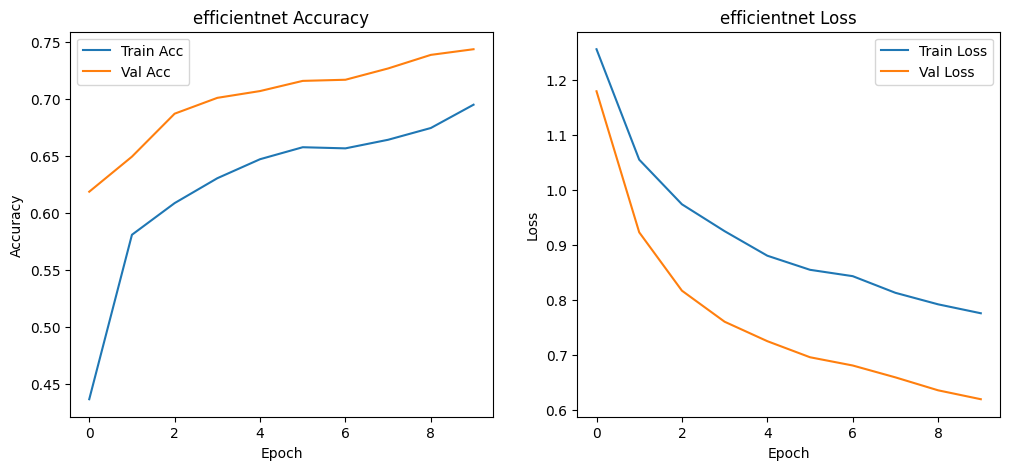

22/22 ━━━━━━━━━━━━━━━━━━━━ 15s 430ms/step


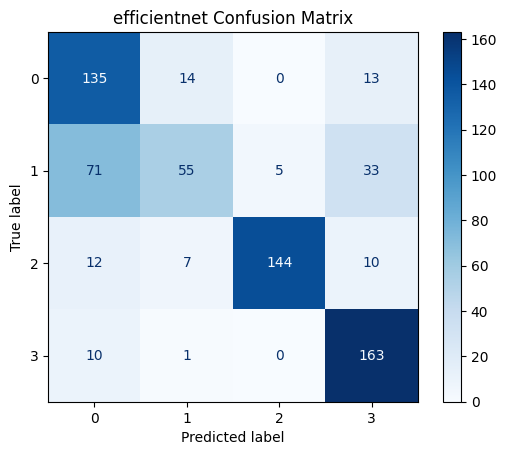


Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.83      0.69       162
           1       0.71      0.34      0.46       164
           2       0.97      0.83      0.89       173
           3       0.74      0.94      0.83       174

    accuracy                           0.74       673
   macro avg       0.75      0.73      0.72       673
weighted avg       0.76      0.74      0.72       673



In [ ]:
efficientnet_history, efficientnet_model = train_model(
    "efficientnet",
    data_dir,
    epochs=10,
    fine_tune=True
)

Fine-tuning the EfficientNet model improved its overall accuracy to about 74% and made it generalize better. Classes 2 and 3 were predicted very well, with F1 scores of 0.89 and 0.83. Class 0 performed okay, but Class 1 still had many mistakes. Overall, the model got better after fine-tuning, but it struggles with Class 1.

**Conclusion**

  - The Custom CNN is the best model, reaching 96% accuracy and doing well on all classes. It has three convolution layers (32 -> 64 -> 128 filters), MaxPooling, Dropout, and fully connected layers, which fit the dataset of 7,153 images (6,726 unique) perfectly. This lets it learn important patterns clearly while avoiding overfitting. It is a bit slower than MobileNetV2 because it does more calculations per image.

  - MobileNetV2 comes next with 93% accuracy. It is small and fast, using special efficient layers, so it works well on devices with less memory or computing power. EfficientNet (fine-tuned) did worse, with 74% accuracy and especially poor results on Class 1. Even with a fairly large dataset, EfficientNet is very complex and needs more resources. This means it uses more memory, computing power, and GPU time, which makes training slower and running it harder on normal hardware.

  - Overall, the Custom CNN is best for accuracy and learning all classes well, MobileNetV2 is best if speed and low memory use are important, and EfficientNet is less suitable because it performs unevenly and needs a lot of computing power.